In [47]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from typing import Tuple, List, Dict

# Load image

In [48]:
image_path = 'image.jpg'
try:
    img = mpimg.imread(image_path)
    print(f"Image loaded. Dimensions: {img.shape}")
except FileNotFoundError:
    print(f"Error: '{image_path}' not found. Creating a dummy image.")
    img = np.random.rand(640, 640, 3) * 255
    img = img.astype(np.uint8)

# Check if image is RGB and split channels
if img.ndim == 3 and img.shape[2] == 3:
    R_channel = img[:, :, 0].astype(float) # Convert to float for SVD
    G_channel = img[:, :, 1].astype(float)
    B_channel = img[:, :, 2].astype(float)
    print("RGB channels extracted.")
else:
    print("Image is not RGB. Exiting.")
    exit()

Image loaded. Dimensions: (360, 640, 3)
RGB channels extracted.


Size of channel R: (360, 640)
Size of channel G: (360, 640)
Size of channel B: (360, 640)


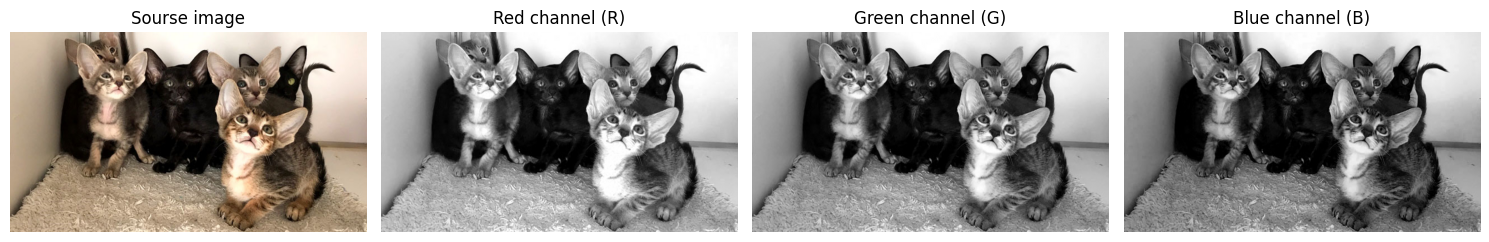


Channels R, G, B have been successfully extracted and are ready for further processing.


In [49]:
if img.ndim == 3 and img.shape[2] == 3:
    R_channel = img[:, :, 0]
    G_channel = img[:, :, 1]
    B_channel = img[:, :, 2]

    print(f"Size of channel R: {R_channel.shape}")
    print(f"Size of channel G: {G_channel.shape}")
    print(f"Size of channel B: {B_channel.shape}")

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 4, 1)
    plt.imshow(img)
    plt.title('Sourse image')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(R_channel, cmap='gray')
    plt.title('Red channel (R)')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(G_channel, cmap='gray')
    plt.title('Green channel (G)')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(B_channel, cmap='gray')
    plt.title('Blue channel (B)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    print("\nChannels R, G, B have been successfully extracted and are ready for further processing.")
else:
    print("The image is not RGB (or has different dimensions). Please choose an image with 3 channels.")
    R_channel, G_channel, B_channel = None, None, None


# SVD methods
## Power method

In [50]:

# --- Helper functions for Power Method ---

def _run_power_iteration(M: np.ndarray, N: int, initial_vector: np.ndarray) -> Tuple[np.ndarray, float]:
    """
    Performs the power iteration for a given matrix M.
    Returns the dominant eigenvector and its norm.
    """
    v_approx = initial_vector
    for _ in range(N):
        v_approx = M @ v_approx
        norm_v_approx = np.linalg.norm(v_approx)
        if norm_v_approx < 1e-10:
            # Warning: Power method vector became near-zero. Breaking.
            break
        v_approx = v_approx / norm_v_approx
    return v_approx, np.linalg.norm(v_approx)

def _calculate_singular_value_and_u(A: np.ndarray, v: np.ndarray, lambda_val: float, singular_value_idx: int) -> Tuple[float, np.ndarray]:
    """
    Calculates the singular value and the corresponding left singular vector u.
    Handles potential negative eigenvalues.
    """
    if lambda_val < 0:
        print(f"Warning: Negative eigenvalue ({lambda_val:.2e}) encountered for singular value {singular_value_idx}. Taking absolute value.")
        sigma_val = np.sqrt(abs(lambda_val))
    else:
        sigma_val = np.sqrt(lambda_val)

    if sigma_val < 1e-10:
        print(f"Warning: Singular value {singular_value_idx} is near zero ({sigma_val:.2e}). Cannot compute corresponding u vector.")
        return 0.0, np.array([]) # Return 0 and empty array to indicate failure

    u_val = (A @ v) / sigma_val
    # Ensure u_val is normalized
    u_val = u_val / np.linalg.norm(u_val)
    return sigma_val, u_val

# --- SVD using Power Method ---

def svd_power_method(A: np.ndarray, k: int, N_iterations: int) -> Tuple[List[float], np.ndarray, np.ndarray]:
    """
    Computes the first k singular values and vectors of matrix A using the power method with deflation.
    Args:
        A: The input matrix (np.ndarray).
        k: The number of singular values/vectors to compute (int).
        N_iterations: The number of iterations for the power method (int).
    Returns:
        A tuple containing:
        - singular_values_sorted: A list of singular values, sorted in descending order.
        - U_matrix: The matrix of left singular vectors (np.ndarray).
        - V_T_matrix: The transpose of the matrix of right singular vectors (np.ndarray).
    """
    m, n = A.shape
    singular_values: List[float] = []
    U_vectors: List[np.ndarray] = []
    V_vectors: List[np.ndarray] = []

    A_current = np.copy(A).astype(float)

    for i in range(k):
        M = A_current.T @ A_current

        v_approx_initial = np.random.rand(n)
        v_approx_initial = v_approx_initial / np.linalg.norm(v_approx_initial)

        v_approx, final_norm = _run_power_iteration(M, N_iterations, v_approx_initial)
        
        if final_norm < 1e-10:
            print(f"Warning: Power method for singular value {i} converged to a near-zero vector. Stopping SVD calculation.")
            break

        lambda_val = v_approx.T @ M @ v_approx
        
        sigma_val, u_val = _calculate_singular_value_and_u(A_current, v_approx, lambda_val, i)

        if sigma_val == 0.0 and u_val.size == 0:
            break

        singular_values.append(sigma_val)
        U_vectors.append(u_val)
        V_vectors.append(v_approx)

        A_current = A_current - sigma_val * np.outer(u_val, v_approx)

    if not singular_values:
        return [], np.array([]), np.array([])

    sorted_components = sorted(zip(singular_values, U_vectors, V_vectors), key=lambda x: x[0], reverse=True)
    
    singular_values_sorted = [comp[0] for comp in sorted_components]
    U_matrix = np.array([comp[1] for comp in sorted_components]).T
    V_matrix = np.array([comp[2] for comp in sorted_components]).T

    return singular_values_sorted, U_matrix, V_matrix.T


## Jacobi method

In [51]:
# --- Helper functions for Jacobi Method ---

def _find_max_off_diagonal_element(matrix: np.ndarray) -> Tuple[float, int, int]:
    """
    Finds the largest off-diagonal element (in absolute value) and its indices.
    """
    n = matrix.shape[0]
    max_val = 0.0
    p, q = 0, 0
    for r in range(n):
        for c in range(r + 1, n):
            if abs(matrix[r, c]) > max_val:
                max_val = abs(matrix[r, c])
                p, q = r, c
    return max_val, p, q

def _calculate_jacobi_rotation_params(matrix: np.ndarray, p: int, q: int) -> Tuple[float, float, float]:
    """
    Calculates the rotation angle (theta), cosine (c), and sine (s) for a Jacobi rotation.
    """
    if matrix[p, p] == matrix[q, q]:
        theta = np.pi / 4.0 * np.sign(matrix[p, q])
    else:
        theta = 0.5 * np.arctan2(2 * matrix[p, q], matrix[p, p] - matrix[q, q])
    
    c = np.cos(theta)
    s = np.sin(theta)
    return theta, c, s

def _apply_jacobi_rotation(matrix: np.ndarray, V_matrix: np.ndarray, p: int, q: int, c: float, s: float) -> Tuple[np.ndarray, np.ndarray]:
    """
    Applies a Jacobi rotation to the current matrix A_k and updates the eigenvector matrix V.
    """
    n = matrix.shape[0]
    
    A_k_new = np.copy(matrix)
    V_new = np.copy(V_matrix)

    # Update A_k
    for i in range(n):
        if i != p and i != q:
            temp_pi = matrix[p, i] * c + matrix[q, i] * s
            temp_qi = -matrix[p, i] * s + matrix[q, i] * c
            A_k_new[p, i] = temp_pi
            A_k_new[i, p] = temp_pi
            A_k_new[q, i] = temp_qi
            A_k_new[i, q] = temp_qi

    A_k_new[p, p] = matrix[p, p] * c * c + matrix[q, q] * s * s + 2 * matrix[p, q] * c * s
    A_k_new[q, q] = matrix[p, p] * s * s + matrix[q, q] * c * c - 2 * matrix[p, q] * c * s
    A_k_new[p, q] = 0.0
    A_k_new[q, p] = 0.0

    # Update V_matrix (eigenvectors)
    for i in range(n):
        temp_ip = V_matrix[i, p] * c + V_matrix[i, q] * s
        temp_iq = -V_matrix[i, p] * s + V_matrix[i, q] * c
        V_new[i, p] = temp_ip
        V_new[i, q] = temp_iq

    return A_k_new, V_new

def jacobi_eigenvalues(A_sym: np.ndarray, tol: float = 1e-9, max_iter: int = 2000) -> Tuple[np.ndarray, np.ndarray, int]:
    """
    Computes eigenvalues and eigenvectors of a symmetric matrix using the Jacobi rotation method.
    """
    n = A_sym.shape[0]
    V = np.eye(n)
    A_k = np.copy(A_sym).astype(float)

    if not np.allclose(A_k, A_k.T):
        raise ValueError("Input matrix A_sym must be symmetric for Jacobi method.")

    num_iterations = 0
    for _ in range(max_iter):
        num_iterations += 1
        
        max_val, p, q = _find_max_off_diagonal_element(A_k)
        
        if max_val < tol:
            break

        if n == 1 or (p == 0 and q == 0 and max_val == 0.0): # For 1x1 matrix or already diagonal
            break

        theta, c, s = _calculate_jacobi_rotation_params(A_k, p, q)
        A_k, V = _apply_jacobi_rotation(A_k, V, p, q, c, s)
    
    eigenvalues = np.diag(A_k)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues_sorted = eigenvalues[sorted_indices]
    eigenvectors_sorted = V[:, sorted_indices]

    return eigenvalues_sorted, eigenvectors_sorted, num_iterations

# --- SVD using Jacobi Method ---

def svd_jacobi_method(A: np.ndarray, jacobi_tol: float = 1e-8, jacobi_max_iter: int = 2000) -> Tuple[List[float], np.ndarray, np.ndarray]:
    """
    Computes SVD components of matrix A using the Jacobi method for eigenvalues of A.T @ A.
    Args:
        A: The input matrix (np.ndarray).
        jacobi_tol: Tolerance for Jacobi method convergence.
        jacobi_max_iter: Maximum iterations for Jacobi method.
    Returns:
        Tuple: (singular_values, U_matrix, V_T_matrix).
    """
    m, n = A.shape
    A_TA = A.T @ A.astype(float) # Ensure float type

    eigenvalues_jacobi, V_jacobi, _ = jacobi_eigenvalues(A_TA, tol=jacobi_tol, max_iter=jacobi_max_iter)
    
    singular_values_jacobi = np.sqrt(np.maximum(0, eigenvalues_jacobi)).tolist() # Ensure non-negative before sqrt
    
    U_jacobi_list: List[np.ndarray] = []
    num_singular_values = min(m, n)
    
    for i in range(num_singular_values):
        if i < len(singular_values_jacobi) and singular_values_jacobi[i] > 1e-10:
            u_vec = (A @ V_jacobi[:, i]) / singular_values_jacobi[i]
            U_jacobi_list.append(u_vec / np.linalg.norm(u_vec))
        else:
            # For zero singular values, we can append a zero vector or find a basis for null(A.T)
            # For practical SVD, we often only care about non-zero singular values.
            # For a full U matrix, this part would be more complex.
            U_jacobi_list.append(np.zeros(m)) # Placeholder for zero singular values

    U_jacobi = np.array(U_jacobi_list).T
    
    return singular_values_jacobi, U_jacobi, V_jacobi.T


## QR method

In [52]:
# --- SVD using QR Iteration Method for Eigenvalues ---

def eigen_qr_method(A_sym: np.ndarray, tol: float = 1e-9, max_iter: int = 1000) -> Tuple[np.ndarray, np.ndarray, int]:
    """
    Computes eigenvalues and eigenvectors of a symmetric matrix using a basic QR iteration.
    Note: This is a basic implementation without shifts, which can be slow for large matrices.
    Args:
        A_sym: The input symmetric matrix (np.ndarray).
        tol: Tolerance for convergence (float).
        max_iter: Maximum number of iterations (int).
    Returns:
        A tuple containing:
        - eigenvalues: Array of eigenvalues (np.ndarray).
        - eigenvectors: Matrix of eigenvectors (np.ndarray, columns are eigenvectors).
        - iterations: Number of iterations performed (int).
    """
    n = A_sym.shape[0]
    Q_accumulated = np.eye(n) # Accumulates Q matrices to get eigenvectors
    A_k = np.copy(A_sym).astype(float)

    if not np.allclose(A_k, A_k.T):
        raise ValueError("Input matrix A_sym must be symmetric for QR iteration.")

    num_iterations = 0
    for _ in range(max_iter):
        num_iterations += 1
        
        # QR decomposition of A_k
        Q, R = np.linalg.qr(A_k)
        
        # Next iteration: A_k+1 = R @ Q
        A_k = R @ Q
        
        # Accumulate Q for eigenvectors
        Q_accumulated = Q_accumulated @ Q

        # Check for convergence: sum of absolute values of off-diagonal elements
        off_diag_norm = np.linalg.norm(A_k - np.diag(np.diag(A_k)), 'fro')
        if off_diag_norm < tol:
            break
    
    eigenvalues = np.diag(A_k)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues_sorted = eigenvalues[sorted_indices]
    eigenvectors_sorted = Q_accumulated[:, sorted_indices] # Eigenvectors are columns of accumulated Q

    return eigenvalues_sorted, eigenvectors_sorted, num_iterations

def svd_qr_method(A: np.ndarray, qr_tol: float = 1e-8, qr_max_iter: int = 1000) -> Tuple[List[float], np.ndarray, np.ndarray]:
    """
    Computes SVD components of matrix A using QR iteration for eigenvalues of A.T @ A.
    Args:
        A: The input matrix (np.ndarray).
        qr_tol: Tolerance for QR iteration convergence.
        qr_max_iter: Maximum iterations for QR method.
    Returns:
        Tuple: (singular_values, U_matrix, V_T_matrix).
    """
    m, n = A.shape
    A_TA = A.T @ A.astype(float)

    eigenvalues_qr, V_qr, _ = eigen_qr_method(A_TA, tol=qr_tol, max_iter=qr_max_iter)
    
    singular_values_qr = np.sqrt(np.maximum(0, eigenvalues_qr)).tolist()
    
    U_qr_list: List[np.ndarray] = []
    num_singular_values = min(m, n)

    for i in range(num_singular_values):
        if i < len(singular_values_qr) and singular_values_qr[i] > 1e-10:
            u_vec = (A @ V_qr[:, i]) / singular_values_qr[i]
            U_qr_list.append(u_vec / np.linalg.norm(u_vec))
        else:
            U_qr_list.append(np.zeros(m))

    U_qr = np.array(U_qr_list).T

    return singular_values_qr, U_qr, V_qr.T


## Full SVD

In [53]:
# --- Unified SVD function ---

def perform_svd(A: np.ndarray, method: str, **kwargs) -> Tuple[List[float], np.ndarray, np.ndarray]:
    """
    Performs SVD on matrix A using the specified method.
    Args:
        A: The input matrix.
        method: SVD method to use ('power', 'jacobi', 'qr').
        **kwargs: Additional arguments for specific methods (e.g., k, N_iterations for power; tol, max_iter for jacobi/qr).
    Returns:
        Tuple: (singular_values, U_matrix, V_T_matrix).
    """
    if method == 'power':
        k = kwargs.get('k', min(A.shape))
        N_iterations = kwargs.get('N_iterations', 100)
        print(f"  Calculating SVD using Power Method (k={k}, N={N_iterations})...")
        return svd_power_method(A, k, N_iterations)
    elif method == 'jacobi':
        jacobi_tol = kwargs.get('tol', 1e-8)
        jacobi_max_iter = kwargs.get('max_iter', 2000)
        print(f"  Calculating SVD using Jacobi Method (tol={jacobi_tol}, max_iter={jacobi_max_iter})...")
        return svd_jacobi_method(A, jacobi_tol, jacobi_max_iter)
    elif method == 'qr':
        qr_tol = kwargs.get('tol', 1e-8)
        qr_max_iter = kwargs.get('max_iter', 1000) # QR iteration can be very slow without shifts.
        print(f"  Calculating SVD using QR Iteration Method (tol={qr_tol}, max_iter={qr_max_iter})...")
        return svd_qr_method(A, qr_tol, qr_max_iter)
    else:
        raise ValueError("Unsupported SVD method. Choose 'power', 'jacobi', or 'qr'.")



In [54]:
# Define number of iterations to test
N_iterations = [10, 50, 100]
N_an = N_iterations[2] # N for analysis

# Process each channel
channels = {'R': R_channel, 'G': G_channel, 'B': B_channel}

results: Dict[str, Dict[int, Dict[str, any]]] = {} # Use 'any' for value type for flexibility

for channel_name, channel_matrix in channels.items():
    print(f"\nProcessing {channel_name} channel...")
    m, n = channel_matrix.shape
    # Determine k: number of singular values to compute (min(m, n) for full SVD)
    k_to_compute = min(m, n)
    
    results[channel_name] = {}
    
    for N in N_iterations:
        print(f"  Running SVD for N = {N} iterations...")
        
        # Perform SVD using the power method
        singular_values, U_power, V_T_power = power_method_for_svd(channel_matrix, k_to_compute, N)
        
        # Reconstruct the matrix
        if U_power.size == 0 or V_T_power.size == 0 or not singular_values:
            reconstructed_matrix = np.zeros_like(channel_matrix)
            reconstruction_error_norm = np.inf
            print(f"    SVD failed to compute components for N = {N}. Reconstruction not possible.")
        else:
            Sigma_power = np.diag(singular_values)
            reconstructed_matrix = U_power @ Sigma_power @ V_T_power
            
            # Calculate the norm of the difference
            reconstruction_error_norm = np.linalg.norm(channel_matrix - reconstructed_matrix)
            
            print(f"    Reconstruction error (Frobenius norm) for N = {N}: {reconstruction_error_norm:.4f}")
            
        results[channel_name][N] = {
            'singular_values': singular_values,
            'U': U_power,
            'V_T': V_T_power,
            'reconstruction_error_norm': reconstruction_error_norm
        }

print("\n--- Summary of Results ---")
for channel_name, channel_results in results.items():
    print(f"\nChannel: {channel_name}")
    for N, data in channel_results.items():
        print(f"  N = {N}:")
        print(f"    Number of singular values found: {len(data['singular_values'])}")
        print(f"    Top 5 singular values: {[f'{s:.2f}' for s in data['singular_values'][:5]]}")
        print(f"    Reconstruction Error: {data['reconstruction_error_norm']:.4f}")




Processing R channel...
  Running SVD for N = 10 iterations...
    Reconstruction error (Frobenius norm) for N = 10: 4.1031
  Running SVD for N = 50 iterations...
    Reconstruction error (Frobenius norm) for N = 50: 4.0229
  Running SVD for N = 100 iterations...
    Reconstruction error (Frobenius norm) for N = 100: 4.0229

Processing G channel...
  Running SVD for N = 10 iterations...
    Reconstruction error (Frobenius norm) for N = 10: 3.7752
  Running SVD for N = 50 iterations...
    Reconstruction error (Frobenius norm) for N = 50: 3.7722
  Running SVD for N = 100 iterations...
    Reconstruction error (Frobenius norm) for N = 100: 3.7722

Processing B channel...
  Running SVD for N = 10 iterations...
    Reconstruction error (Frobenius norm) for N = 10: 4.3291
  Running SVD for N = 50 iterations...
    Reconstruction error (Frobenius norm) for N = 50: 4.2449
  Running SVD for N = 100 iterations...
    Reconstruction error (Frobenius norm) for N = 100: 4.2430

--- Summary of Res

# Singular values


--- Analyzing Singular Value Distribution (using N=100 iterations) ---


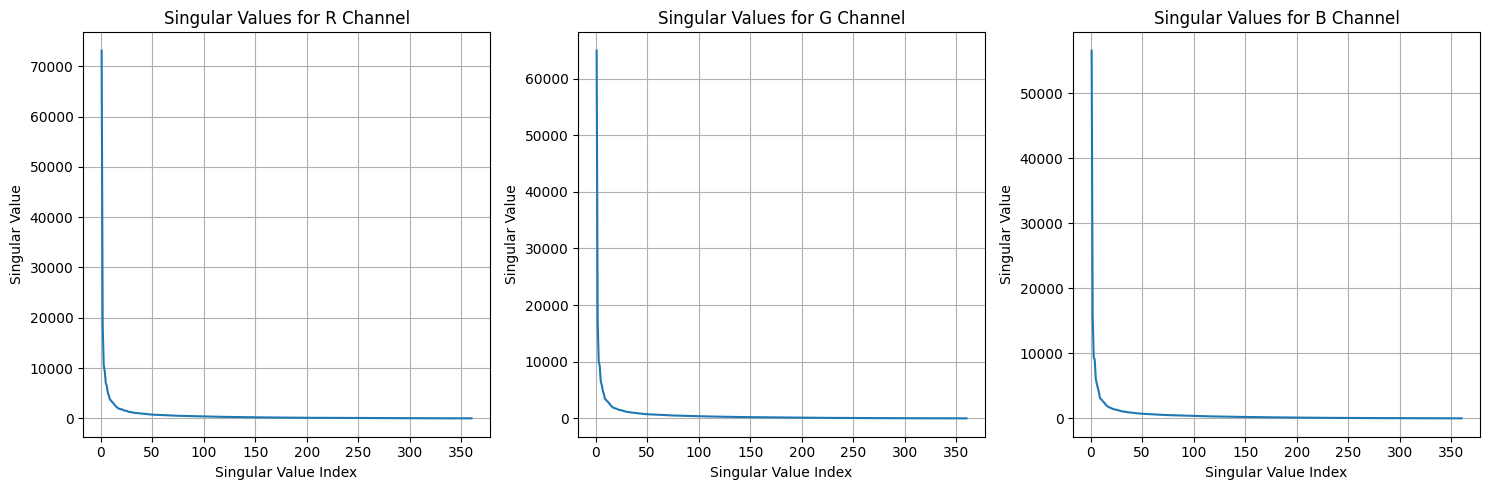

In [55]:
# 1. Analyze singular values and plot their distribution
print("\n--- Analyzing Singular Value Distribution (using N=100 iterations) ---")

channels_to_analyze = {'R': R_channel, 'G': G_channel, 'B': B_channel}
singular_values_data = {}

plt.figure(figsize=(15, 5))

for i, (channel_name, channel_matrix) in enumerate(channels_to_analyze.items()):
    # Get singular values from the results of N=100 iterations
    if N_an in results[channel_name] and results[channel_name][N_an]['singular_values']:
        s_values = results[channel_name][N_an]['singular_values']
        singular_values_data[channel_name] = s_values

        plt.subplot(1, 3, i + 1)
        plt.plot(range(1, len(s_values) + 1), s_values)
        plt.title(f'Singular Values for {channel_name} Channel')
        plt.xlabel('Singular Value Index')
        plt.ylabel('Singular Value')
        plt.grid(True)
    else:
        print(f"Warning: No singular values found for {channel_name} channel with N=100 iterations. Skipping plot.")

plt.tight_layout()
plt.show()


# Image with different rank in SVD decomposition


--- Reconstructing Images with Truncated SVD ---
Reconstructing with k = 1 components...
Reconstructing with k = 5 components...
Reconstructing with k = 10 components...
Reconstructing with k = 20 components...
Reconstructing with k = 50 components...
Reconstructing with k = 100 components...
Reconstructing with k = 200 components...
Reconstructing with k = 360 components...


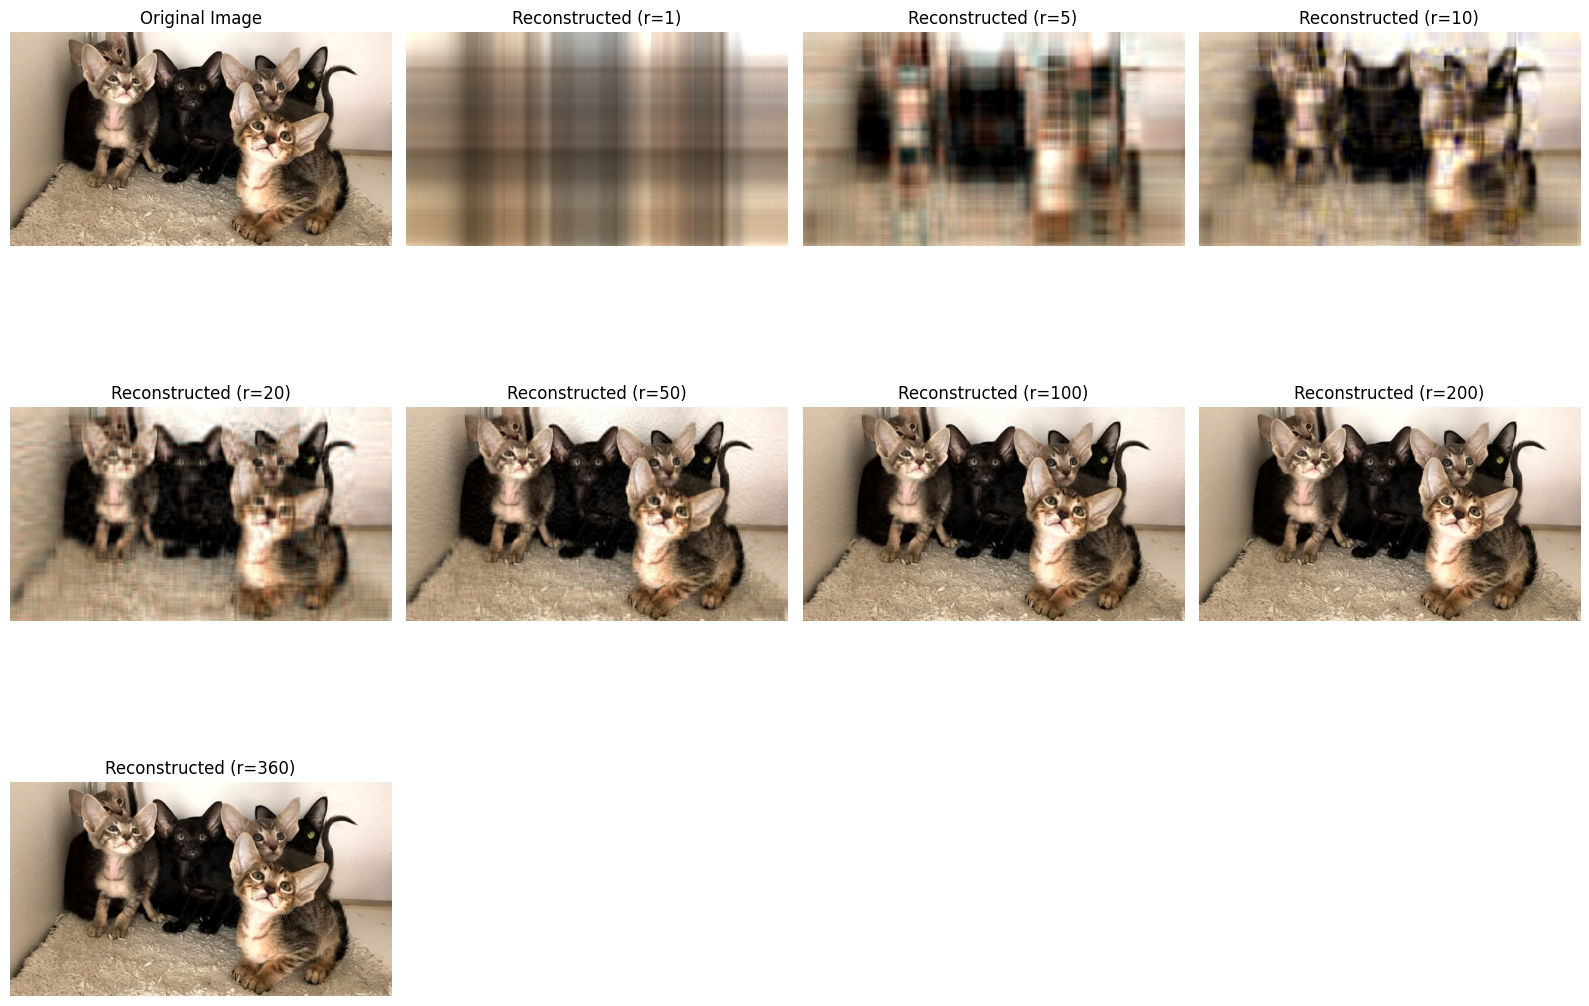

In [56]:
# 2. Truncated SVD and Image Reconstruction
def reconstruct_image_from_svd(U: np.ndarray, s: List[float], V_T: np.ndarray, k: int) -> np.ndarray:
    """
    Reconstructs a matrix using truncated SVD.
    Args:
        U: Left singular vectors matrix.
        s: List of singular values.
        V_T: Transpose of right singular vectors matrix.
        k: Number of singular values/vectors to use for reconstruction.
    Returns:
        The reconstructed matrix.
    """
    if not s or k <= 0:
        return np.zeros((U.shape[0], V_T.shape[1]))

    # Ensure k does not exceed available singular values
    k = min(k, len(s))
    
    # Take top k singular values and corresponding vectors
    U_k = U[:, :k]
    s_k = np.diag(s[:k])
    V_T_k = V_T[:k, :]
    
    reconstructed_matrix = U_k @ s_k @ V_T_k
    return reconstructed_matrix

print("\n--- Reconstructing Images with Truncated SVD ---")

# Define different ranks (number of singular values) for reconstruction
ranks_to_test = [1, 5, 10, 20, 50, 100, 200, min(R_channel.shape)] # Add full rank for comparison

# Store reconstructed images for display
reconstructed_images: Dict[int, np.ndarray] = {}

original_image = np.stack([R_channel, G_channel, B_channel], axis=-1).astype(np.uint8)

# Reconstruct for each rank
for k_rank in ranks_to_test:
    print(f"Reconstructing with k = {k_rank} components...")
    
    # Get U, s, V_T for each channel (using N=100 results)
    U_R = results['R'][N_an]['U']
    s_R = results['R'][N_an]['singular_values']
    V_T_R = results['R'][N_an]['V_T']

    U_G = results['G'][N_an]['U']
    s_G = results['G'][N_an]['singular_values']
    V_T_G = results['G'][N_an]['V_T']

    U_B = results['B'][N_an]['U']
    s_B = results['B'][N_an]['singular_values']
    V_T_B = results['B'][N_an]['V_T']

    # Reconstruct each channel
    reconstructed_R = reconstruct_image_from_svd(U_R, s_R, V_T_R, k_rank)
    reconstructed_G = reconstruct_image_from_svd(U_G, s_G, V_T_G, k_rank)
    reconstructed_B = reconstruct_image_from_svd(U_B, s_B, V_T_B, k_rank)

    # Stack channels to form the full color image
    # Clip values to [0, 255] and convert to uint8 for proper display
    reconstructed_img = np.stack([
        np.clip(reconstructed_R, 0, 255),
        np.clip(reconstructed_G, 0, 255),
        np.clip(reconstructed_B, 0, 255)
    ], axis=-1).astype(np.uint8)
    
    
    reconstructed_images[k_rank] = reconstructed_img

# Display original and reconstructed images
num_plots = len(reconstructed_images) + 1 # +1 for the original image
cols = 4
rows = (num_plots + cols - 1) // cols # Calculate rows needed

plt.figure(figsize=(cols * 4, rows * 4))

plt.subplot(rows, cols, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plot_idx = 2
for k_rank, recon_img in reconstructed_images.items():
    plt.subplot(rows, cols, plot_idx)
    plt.imshow(recon_img)
    plt.title(f'Reconstructed (r={k_rank})')
    plt.axis('off')
    plot_idx += 1

plt.tight_layout()
plt.show()


In [ ]:
# --- Main execution block for comparison ---

print("\n--- Comparing SVD Methods for R Channel ---")

# Choose one channel, e.g., R_channel, for comparison
channel_for_comparison = R_channel
channel_name_for_comparison = 'R'

# Parameters for each method
power_params = {'k': min(channel_for_comparison.shape), 'N_iterations': 100} # Compute all for comparison
jacobi_params = {'tol': 1e-8, 'max_iter': 2000}
qr_params = {'tol': 1e-8, 'max_iter': 1000} # Note: QR iteration without shifts can be very slow

# Store results for plotting
all_singular_values: Dict[str, List[float]] = {}
method_labels: List[str] = []

# 1. Power Method SVD
print(f"\nProcessing {channel_name_for_comparison} channel with Power Method...")
s_power, U_power, V_T_power = perform_svd(channel_for_comparison, 'power', **power_params)
all_singular_values['Power Method (N=100)'] = s_power
method_labels.append('Power Method (N=100)')
print(f"  Power Method: Found {len(s_power)} singular values. Top 5: {[f'{val:.2f}' for val in s_power[:5]]}")


# 2. Jacobi Method SVD
print(f"\nProcessing {channel_name_for_comparison} channel with Jacobi Method...")
s_jacobi, U_jacobi, V_T_jacobi = perform_svd(channel_for_comparison, 'jacobi', **jacobi_params)
all_singular_values['Jacobi Method'] = s_jacobi
method_labels.append('Jacobi Method')
print(f"  Jacobi Method: Found {len(s_jacobi)} singular values. Top 5: {[f'{val:.2f}' for val in s_jacobi[:5]]}")


# 3. QR Iteration Method SVD
print(f"\nProcessing {channel_name_for_comparison} channel with QR Iteration Method...")
s_qr, U_qr, V_T_qr = perform_svd(channel_for_comparison, 'qr', **qr_params)
all_singular_values['QR Method'] = s_qr
method_labels.append('QR Method')
print(f"  QR Method: Found {len(s_qr)} singular values. Top 5: {[f'{val:.2f}' for val in s_qr[:5]]}")


# Plot comparison of singular values
plt.figure(figsize=(12, 7))
for label, s_values in all_singular_values.items():
    plt.plot(range(1, len(s_values) + 1), s_values, label=label)

plt.title(f'Comparison of Singular Values for {channel_name_for_comparison} Channel by Method')
plt.xlabel('Singular Value Index')
plt.ylabel('Singular Value')
plt.legend()
plt.grid(True)
plt.yscale('log') # Use log scale for better visualization of decay
plt.show()

print("\n--- Detailed Comparison of Top Singular Values (First 5) ---")
num_compare = 5
for i in range(num_compare):
    print(f"\nSingular Value {i+1}:")
    for method_label in method_labels:
        s_values = all_singular_values[method_label]
        if i < len(s_values):
            print(f"  {method_label}: {s_values[i]:.4f}")
        else:
            print(f"  {method_label}: N/A (not enough singular values found)")



--- Comparing SVD Methods for R Channel ---

Processing R channel with Power Method...
  Calculating SVD using Power Method (k=360, N=100)...
  Power Method: Found 360 singular values. Top 5: ['73385.06', '18762.49', '10591.03', '9396.24', '7061.50']

Processing R channel with Jacobi Method...
  Calculating SVD using Jacobi Method (tol=1e-08, max_iter=2000)...
